## Árvores de regressão - exercícios 02

Este exercício será uma continuação do anterior, mesma base, mesmas variáveis - vamos tentar buscar a 'melhor árvore'.


*Atenção - Utilizar a base de dados em anexo que é a mesma base que utilizamos na atividade anterior! A base Boston, assim como para a primeira atividade foi descontinuada e não deve ser utilizada*

In [47]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from joblib import Parallel, delayed



### 1. Execute os passos do exercício anterior, até que você tenha uma árvore de regressão predizendo o valor do imóvel na base de treinamento.

In [48]:
df = pd.read_csv('/content/housing.csv')
data = pd.DataFrame(df)

In [49]:
# Carregar os dados (ajuste o caminho do arquivo conforme necessário)
data = pd.read_csv('/content/housing.csv')

# Verificar se 'ocean_proximity' está nas colunas
if 'ocean_proximity' in data.columns:
    # Criar um OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    # Ajustar o encoder à coluna 'ocean_proximity' e transformá-la
    encoded_data = encoder.fit_transform(data[['ocean_proximity']])
    # Criar um DataFrame a partir dos dados codificados
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ocean_proximity']))
    # Concatenar o DataFrame codificado com o DataFrame original, removendo a coluna original 'ocean_proximity'
    data = pd.concat([data, encoded_df], axis=1).drop('ocean_proximity', axis=1)

# Preencher valores nulos com a média da coluna
X = data.drop('median_house_value', axis=1)
X = X.fillna(X.mean())
y = data['median_house_value']


In [50]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
# Instanciar e treinar a árvore de regressão
tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

MSE: 5105514269.101743
R²: 0.610387722163243


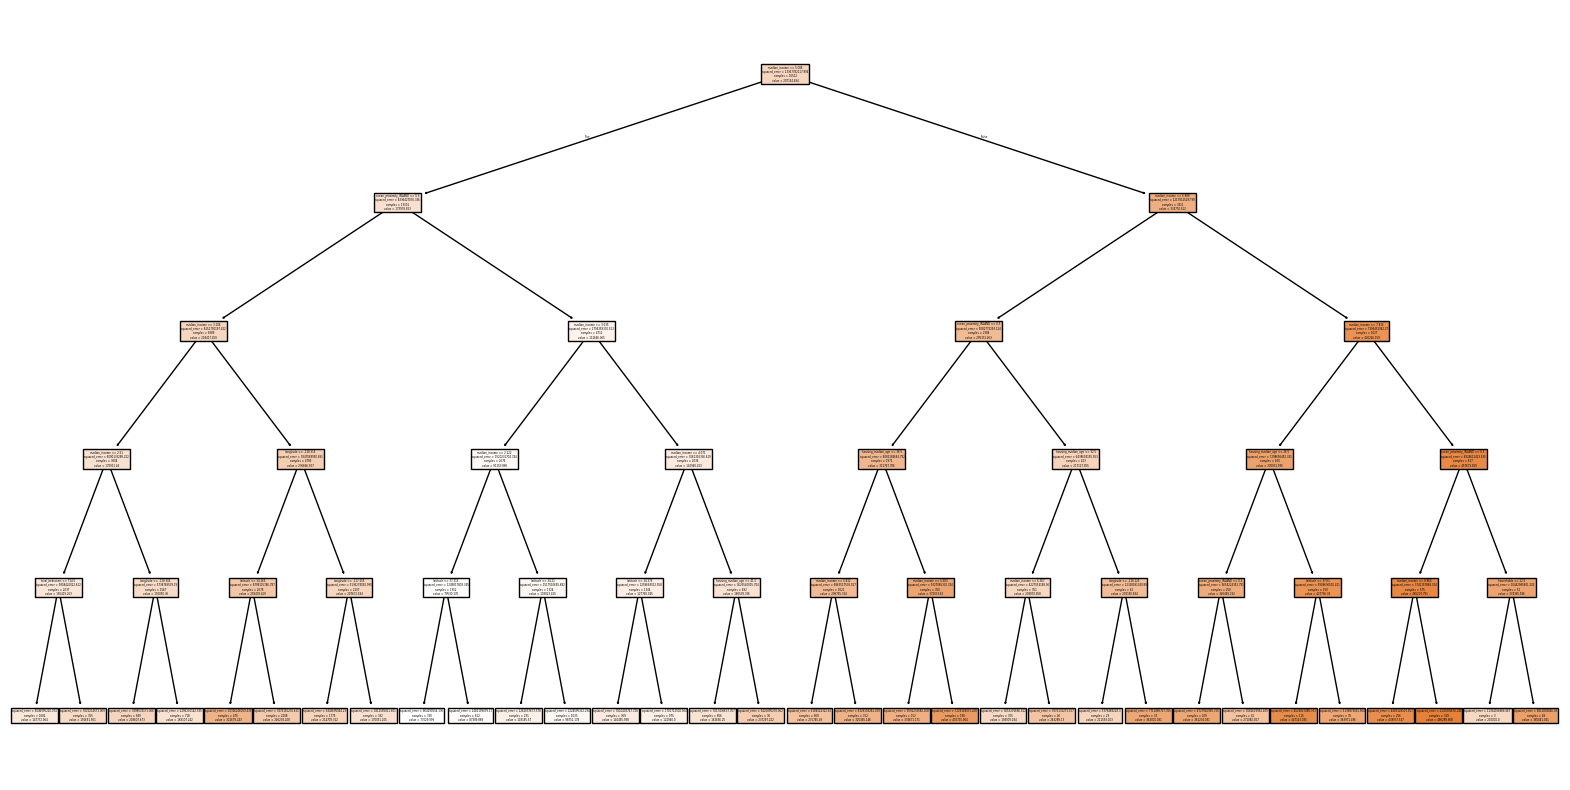

In [52]:
# Ajustar a profundidade máxima para simplificar a árvore
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_regressor.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = tree_regressor.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R²: {r2}")

# Visualizar a árvore de decisão
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_regressor, feature_names=X.columns, filled=True)
plt.show()


### 2.  Calcule o caminho indicado pelos CCP-alfas dessa árvore.

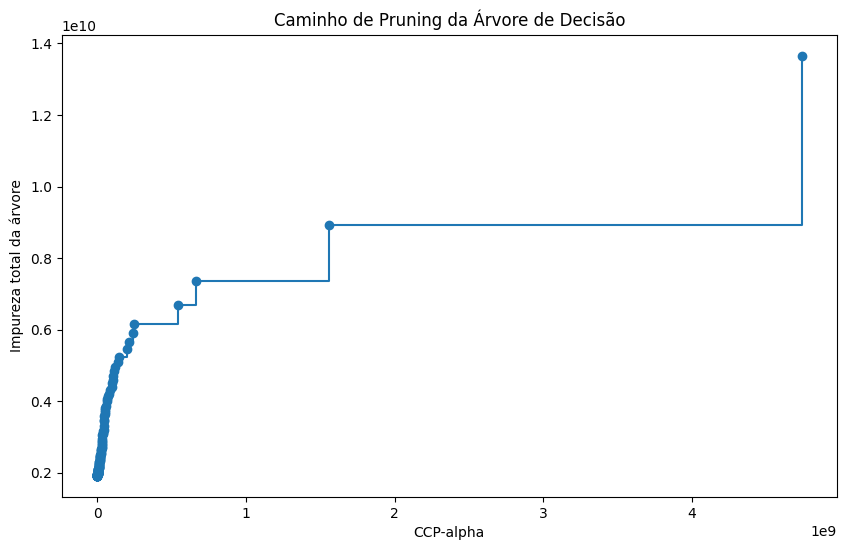

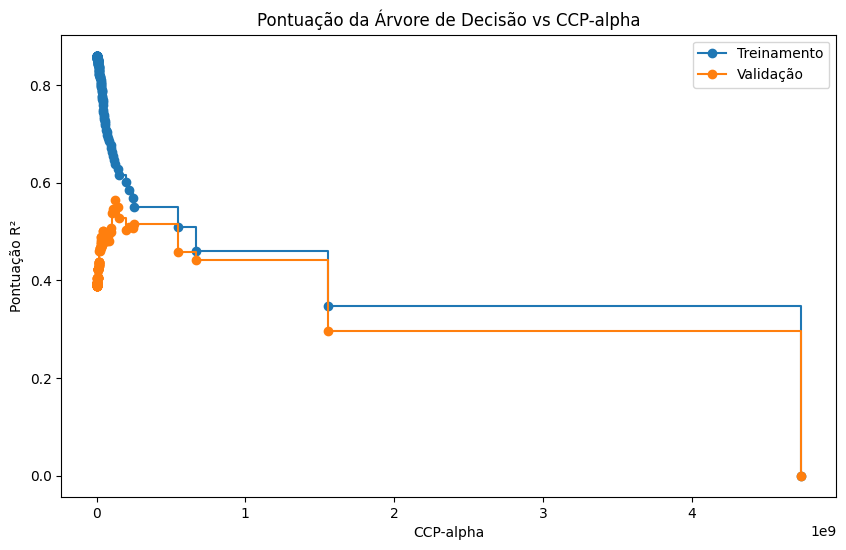

In [53]:
# Dividir os dados em conjuntos de treino e teste
X = data.drop('median_house_value', axis=1)
Y = data['median_house_value']

# Usar apenas uma amostra dos dados para acelerar o treinamento
X_sample, _, y_sample, _ = train_test_split(X, Y, test_size=0.95, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Treinar uma árvore de decisão para encontrar o caminho de pruning com profundidade máxima reduzida
tree_regressor = DecisionTreeRegressor(max_depth=8, random_state=42)
tree_regressor.fit(X_train, y_train)
path = tree_regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plotar as impurezas contra os CCP-alphas
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("CCP-alpha")
plt.ylabel("Impureza total da árvore")
plt.title("Caminho de Pruning da Árvore de Decisão")
plt.show()

# Treinar várias árvores de decisão usando diferentes CCP-alphas
def train_tree(ccp_alpha):
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha, max_depth=8)
    tree.fit(X_train, y_train)
    return tree

trees = Parallel(n_jobs=-1)(delayed(train_tree)(ccp_alpha) for ccp_alpha in ccp_alphas)

# Avaliar o desempenho das árvores usando a base de validação
train_scores = [tree.score(X_train, y_train) for tree in trees]
val_scores = [tree.score(X_test, y_test) for tree in trees]

# Plotar a pontuação das árvores contra os CCP-alphas
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Treinamento", drawstyle="steps-post")
plt.plot(ccp_alphas, val_scores, marker='o', label="Validação", drawstyle="steps-post")
plt.xlabel("CCP-alpha")
plt.ylabel("Pontuação R²")
plt.title("Pontuação da Árvore de Decisão vs CCP-alpha")
plt.legend()
plt.show()

In [54]:
# Exibir o número de árvores treinadas e suas pontuações
print(f"Número de árvores treinadas: {len(trees)}")
print(f"Pontuação de treinamento e validação das árvores:")
for i, (train_score, val_score) in enumerate(zip(train_scores, val_scores)):
    print(f"Árvore {i+1}: CCP-alpha={ccp_alphas[i]}, Treinamento R²={train_score:.4f}, Validação R²={val_score:.4f}")

Número de árvores treinadas: 121
Pontuação de treinamento e validação das árvores:
Árvore 1: CCP-alpha=0.0, Treinamento R²=0.8599, Validação R²=0.3893
Árvore 2: CCP-alpha=96.96969696969697, Treinamento R²=0.8599, Validação R²=0.3893
Árvore 3: CCP-alpha=151.5151515151515, Treinamento R²=0.8599, Validação R²=0.3893
Árvore 4: CCP-alpha=13963.636363636364, Treinamento R²=0.8599, Validação R²=0.3893
Árvore 5: CCP-alpha=76024.24242424243, Treinamento R²=0.8599, Validação R²=0.3893
Árvore 6: CCP-alpha=85729.29292929909, Treinamento R²=0.8599, Validação R²=0.3893
Árvore 7: CCP-alpha=97751.51515151515, Treinamento R²=0.8599, Validação R²=0.3887
Árvore 8: CCP-alpha=129187.87878787878, Treinamento R²=0.8599, Validação R²=0.3887
Árvore 9: CCP-alpha=185472.72727274577, Treinamento R²=0.8599, Validação R²=0.3880
Árvore 10: CCP-alpha=262206.0606060606, Treinamento R²=0.8599, Validação R²=0.3880
Árvore 11: CCP-alpha=306785.92324699636, Treinamento R²=0.8598, Validação R²=0.3889
Árvore 12: CCP-alpha=52

### 3. Para cada valor de alpha obtido no item 2, treine uma árvore com o respectivo alfa, e guarde essa árvore em uma lista.

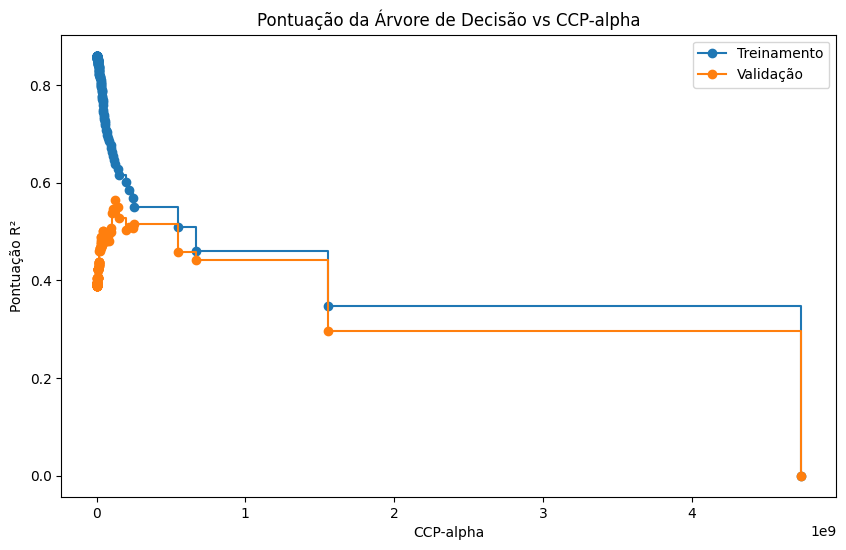

In [55]:
# Treinar várias árvores de decisão usando diferentes CCP-alphas e guardar em uma lista
def train_tree(ccp_alpha):
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha, max_depth=8)
    tree.fit(X_train, y_train)
    return tree

trees = Parallel(n_jobs=-1)(delayed(train_tree)(ccp_alpha) for ccp_alpha in ccp_alphas)

# Avaliar o desempenho das árvores usando a base de validação
train_scores = [tree.score(X_train, y_train) for tree in trees]
val_scores = [tree.score(X_test, y_test) for tree in trees]

# Plotar a pontuação das árvores contra os CCP-alphas
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Treinamento", drawstyle="steps-post")
plt.plot(ccp_alphas, val_scores, marker='o', label="Validação", drawstyle="steps-post")
plt.xlabel("CCP-alpha")
plt.ylabel("Pontuação R²")
plt.title("Pontuação da Árvore de Decisão vs CCP-alpha")
plt.legend()
plt.show()

### 4. Para cada árvore na lista, calcule o MSE da árvore.

Árvore 1: CCP-alpha=0.0, MSE=9372227148.9752
Árvore 2: CCP-alpha=96.96969696969697, MSE=9372227148.9752
Árvore 3: CCP-alpha=151.5151515151515, MSE=9372227148.9752
Árvore 4: CCP-alpha=13963.636363636364, MSE=9372227148.9752
Árvore 5: CCP-alpha=76024.24242424243, MSE=9372227148.9752
Árvore 6: CCP-alpha=85729.29292929909, MSE=9372227148.9752
Árvore 7: CCP-alpha=97751.51515151515, MSE=9381575760.0863
Árvore 8: CCP-alpha=129187.87878787878, MSE=9381575760.0863
Árvore 9: CCP-alpha=185472.72727274577, MSE=9391485470.2312
Árvore 10: CCP-alpha=262206.0606060606, MSE=9391485470.2312
Árvore 11: CCP-alpha=306785.92324699636, MSE=9378017594.7441
Árvore 12: CCP-alpha=520296.9696969697, MSE=9378017594.7441
Árvore 13: CCP-alpha=794206.0606060605, MSE=9378017594.7441
Árvore 14: CCP-alpha=861432.3232323295, MSE=9362233256.3115
Árvore 15: CCP-alpha=1010101.0101009854, MSE=9361744796.8375
Árvore 16: CCP-alpha=1125824.2424242424, MSE=9361744796.8375
Árvore 17: CCP-alpha=1271296.9696969697, MSE=9361744796.8

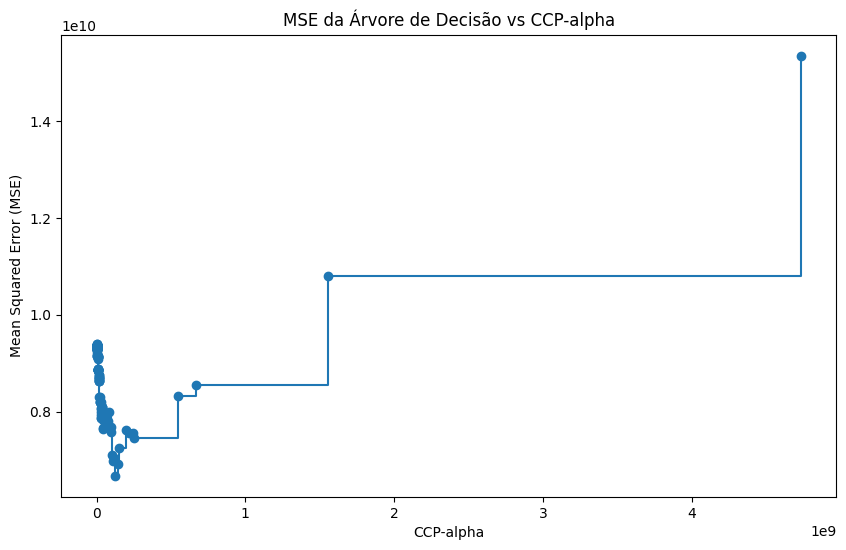

In [56]:
# Lista para armazenar os MSEs
mse_values = []

# Calcular o MSE para cada árvore na lista
for i, tree in enumerate(trees):
    y_pred = tree.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    print(f"Árvore {i+1}: CCP-alpha={ccp_alphas[i]}, MSE={mse:.4f}")

# Plotar os MSEs contra os valores de CCP-alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, mse_values, marker='o', drawstyle="steps-post")
plt.xlabel("CCP-alpha")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE da Árvore de Decisão vs CCP-alpha")
plt.show()


### 5. Monte um gráfico do MSE pelo alpha, escolha um valor de alpha perto do ponto de mínimo do MSE

In [57]:
# Encontrar o valor de alpha próximo ao ponto de mínimo do MSE
min_mse_index = mse_values.index(min(mse_values))
optimal_ccp_alpha = ccp_alphas[min_mse_index]

print(f"Alpha ótimo: {optimal_ccp_alpha}, com MSE: {mse_values[min_mse_index]:.4f}")


Alpha ótimo: 123469115.2486471, com MSE: 6674245727.1609


### 6. Calcule o R-quadrado dessa árvore encontrada no item acima

In [58]:
# Treinar a árvore de decisão usando o alpha ótimo
optimal_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_ccp_alpha, max_depth=8)
optimal_tree.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_optimal = optimal_tree.predict(X_test)

# Calcular o R-quadrado
r2_optimal = r2_score(y_test, y_pred_optimal)

print(f"R-quadrado da árvore com alpha ótimo ({optimal_ccp_alpha}): {r2_optimal:.4f}")


R-quadrado da árvore com alpha ótimo (123469115.2486471): 0.5651


### 7. Visualize esta árvore.

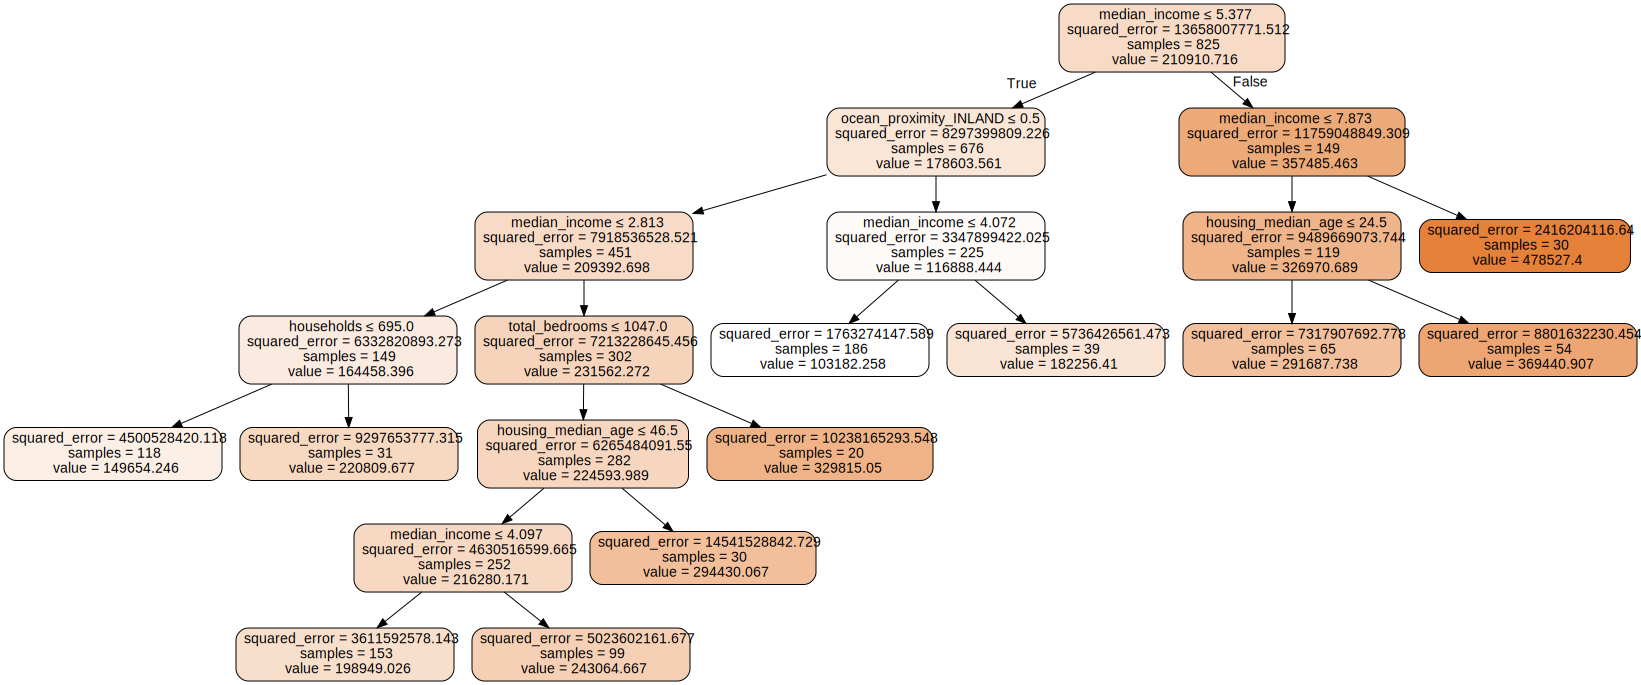

In [59]:
from sklearn.tree import export_graphviz
import graphviz

# Exportar a árvore de decisão em formato dot
dot_data = export_graphviz(optimal_tree, out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True)

# Visualizar a árvore de decisão
graph = graphviz.Source(dot_data)
graph.render("arvore_otima_decisao")  # Salva a árvore em um arquivo PDF chamado 'arvore_otima_decisao.pdf'
graph
